# Real-time Ad Bidding Price Predictor
_Author: Eric Tran_

The task in this dataset is to predict the base price an advertiser would need to pay to win an auction for their ad to be served on a publisher's website. We're asked to predict next month's reserve base prices. The publisher's objective is to determine a reserve price for their inventory to maximize revenue. The minimum (reserve) price will then be set by the Publisher in their programmatic advertising platform.

This is a supervised, regression machine learning problem.

### About the Dataset

- This data was uploaded to Kaggle on 2020-06-02 by Saurav Anand.
- Each row in the data represents the actual revenue generated by a publisher, and not at the bid level.
- Data dictionary below

| Key | Value Type | Definition |
| :- | :- | :- |
| date | string | The date the ad was served on |
| advertiser_id | integer |  each id denotes a different bidder in the auction |
| order_id | integer | each id denotes an order generated at the time of creation. Each order ID is useful to ensure you and others are referring to the same Advertiser campaign. |
| line_item_type_id | integer | line items contain information about how specific ads are served on a website along with pricing and other delivery details. For example: Sponsorship, Standard, Network, Bulk, Price Priority. Line item types also have different priorities, or how a line item competes with other line items. Not all line items have the same importance. Some line items may be contractually guaranteeded to serve or may promise more revenue than others. These can be priotiezed higher than other line items. |
| monetization_channel_id | integer |  it describes the mode through which demand partner integrates with a particular publisher - it can be header bidding (running via prebid.js), dynamic allocation, exchange bidding, direct etc |
| site_id | integer | each id denotes a different website |
| ad_type_id | integer | each id denotes a different ad_type. These can be display ads , video ads, text ads etc |
| ad_unit_id | integer | each id denotes a different ad unit (one page can have more than one ad units) | 
| geo_id | integer |  each id denotes a different country. our maximum traffic is from english speaking countries |
| device_category_id | integer | each id denoted a different device_category like desktop , mobile, tablet |
| os_id | integer | each id denotes a different operating system for mobile device category only (android , ios etc) . for all other device categories, osid will correspond to not_mobile |
| integration_type_id | integer |  it describes how the demand partner is setup within a publisher's ecosystem - can be adserver (running through the publisher adserver) or hardcoded |
| total_impressions | float | measurement column measuring the impressions for the particular set of dimensions |
| viewable_impressions | float | Number of impressions on the site that were viewable out of all measurable impressions. A display ad is counted as viewable if at least 50% of its area was displayed on screen for at least one second |
| measureable_impressions | float | Impressions that were measurable by Active View out of the total number of eligible impressions. This value should generally be close to 100%. For example, an impression that is rendering in a cross-domain iframe may not be measurable. Active View is a technology on YouTube and certain Display Network websites and mobile apps that allows Google Ads to determine if your ad is viewable by potential customers. |
| total_revenue | float | measurement column measuring the revenue for the particular set of dimensions |
| revenue_share_percentage | float | not every advertiser gives all the revenue to the publisher. They charge a certain share for the services they provide. This captures the fraction of revenue that will actually reach the publishers pocket |
| cpm | float | CPM: cost-per-thousand impressions. A measure that calculates the Adverrtiser's cost for 1000 impressions

### Install Required Libraries

In [ ]:
!pip install pydot --quiet

### Import Libraries

In [1]:
# Data analysis and wrangling
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pydot

# show plots in Jupyter Notebook browser
%matplotlib inline 

# Jupyter enviornment
from IPython.core.display import display, HTML

# Datetime
import datetime

# Machine Learning
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor

# ML helper functions
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

In [5]:
import sklearn

sklearn.__version__

'0.22.2.post1'

### Configure Jupyter Enviornment

In [ ]:
# Set pandas display configurations with more rows, columns, and greater column width
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 255)

# Expand the jupyter container to have more working space
display(HTML("<style>.container {width:80% !important} </style>"))

# Configure Plotting Style Guide
plt.style.use('ggplot')

### Load the Data

In [ ]:
# Hook up google drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read in the file
relative_path = '/content/drive/MyDrive/Data/rtb-ad-dataset.csv'
ads_df = pd.read_csv(relative_path)

### Examine the Data

In [ ]:
# Display the first 5 rows
ads_df.head()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
0,2019-06-30 00:00:00,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0,2,16,1
1,2019-06-30 00:00:00,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0,0,6,1
2,2019-06-30 00:00:00,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0,0,4,1
3,2019-06-30 00:00:00,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0,0,4,1
4,2019-06-30 00:00:00,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0,0,4,1


### Shape of Data

In [ ]:
# Display the number of rows and columns
ads_df.shape

(567291, 17)

### Check for Missing Data

In [ ]:
ads_df.isnull().sum()

date                       0
site_id                    0
ad_type_id                 0
geo_id                     0
device_category_id         0
advertiser_id              0
order_id                   0
line_item_type_id          0
os_id                      0
integration_type_id        0
monetization_channel_id    0
ad_unit_id                 0
total_impressions          0
total_revenue              0
viewable_impressions       0
measurable_impressions     0
revenue_share_percent      0
dtype: int64

### Feature Engineering
Lets convert the date from string to datetime data type

In [ ]:
# Replace existing date column with datetime
ads_df['date'] = pd.to_datetime(ads_df['date'])

Now lets create a function that will extract the Year, Month, Day, Weekday, and Day of Week

In [ ]:
# Function to extract the Year, Month, Day, Weekday, and Day Of Week from date column in dataframe
def get_date_attributes(df):
    
    # Retrieve year of date
    ads_df['year'] = ads_df['date'].apply(lambda x: x.year)
    
    # Retrieve month of date
    ads_df['month'] = ads_df['date'].apply(lambda x: x.month)
    
    # Retrieve day of date
    ads_df['day'] = ads_df['date'].apply(lambda x: x.day)
    
    # Retrieve month of date
    ads_df['weekday'] = ads_df['date'].apply(lambda x: x.weekday())    

    # Retrieve month of date
    ads_df['day_of_week'] = ads_df['date'].apply(lambda x: x.strftime("%A"))
    
# Retrieve date attributes
get_date_attributes(ads_df)

Next, compute the CPM
- _CPM = (Cost to the Advertiser / No. of Impressions) x 1000_

In [ ]:
# Calculate the CPM. CPM = (total_revenue / measurable_impressions) x revenue_share_percent x 1000. 
def revenue_per_impression(r, i):
    return r / i if i else 0

ads_df['revenue_per_imp'] = ads_df.apply(lambda x: revenue_per_impression(((x['total_revenue'])*x['revenue_share_percent']),x['measurable_impressions']) , axis=1)
ads_df['CPM'] = ads_df['revenue_per_imp'].apply(lambda x: x*1000)

### Data Preparation
Here we look at the dimensions of the data and identify any anomalies, missing data, outliers that will affect our model.

In [ ]:
ads_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
site_id,567291.0,347.11,2.93,342.00,345.0,346.0,350.00,351.00
ad_type_id,567291.0,10.22,1.22,10.00,10.0,10.0,10.00,17.00
geo_id,567291.0,110.23,66.18,1.00,39.0,122.0,183.00,308.00
device_category_id,567291.0,1.90,0.79,1.00,1.0,2.0,3.00,5.00
advertiser_id,567291.0,262.08,627.33,8.00,79.0,88.0,139.00,2646.00
order_id,567291.0,1951.27,1652.55,45.00,45.0,3438.0,3460.00,3489.00
line_item_type_id,567291.0,12.63,6.81,3.00,4.0,11.0,19.00,20.00
os_id,567291.0,57.22,1.96,15.00,56.0,57.0,58.00,60.00
integration_type_id,567291.0,1.00,0.00,1.00,1.0,1.0,1.00,1.00
monetization_channel_id,567291.0,14.43,7.14,1.00,4.0,19.0,19.00,21.00


Lets filter out all observations with negative CPM values and remove outliers from our dataset

In [ ]:
# Save a copy of the original dataframe in new variable
ads_df_original = ads_df.copy()

# Filter out all oberservations with negative CPM
ads_df = ads_df[ads_df['CPM'] >= 0]

# Filter out the outliers from the dataset 
ads_df = ads_df[ads_df['CPM'] <= ads_df['CPM'].quantile(0.95)]

print('***** DATASET *****')
print("Original: {}".format(ads_df_original.shape))
print("Filtered: {}".format(ads_df.shape))
print('')
print("Remaining: {:.2f}%".format((ads_df.shape[0] /ads_df_original.shape[0])*100))

***** DATASET *****
Original: (567291, 24)
Filtered: (538926, 24)

Remaining: 95.00%


In [ ]:
# Save a copy of processed dataset
ads_df.to_csv('rtb-ad-dataset-processed.csv')

### Feature Selection

In [ ]:
ads_df.columns

Index(['date', 'site_id', 'ad_type_id', 'geo_id', 'device_category_id',
       'advertiser_id', 'order_id', 'line_item_type_id', 'os_id',
       'integration_type_id', 'monetization_channel_id', 'ad_unit_id',
       'total_impressions', 'total_revenue', 'viewable_impressions',
       'measurable_impressions', 'revenue_share_percent', 'year', 'month',
       'day', 'weekday', 'day_of_week', 'revenue_per_imp', 'CPM'],
      dtype='object')

**Criteria**

- We will drop 'total_impressions', 'viewable_impressions', 'measureable_impressions', 'unfilled_impressions', and 'total_revenue' as we used these features to calculate CPM
- We will drop 'integration_type_id' and 'revenue_share_percent' because these features only contain one value
- We will drop 'date', 'year', 'month', 'day', 'weekday', 'day_of_week' because these are mainly used for EDA
- We will drop 'revenue_per_imp' because is just a proxy to 'CPM'

In [ ]:
feature_list = ['advertiser_id', 
                'order_id', 
                'monetization_channel_id', 
                'line_item_type_id', 
                'site_id', 
                'ad_unit_id', 
                'ad_type_id', 
                'geo_id', 
                'device_category_id', 
                'os_id']

target_col = 'CPM'

X = ads_df[feature_list].copy()
y = ads_df[target_col].copy()

In [ ]:
print(X.shape)
print(y.shape)

(538926, 10)
(538926,)


### Train/Test Split

Split the dataset so 70% is used for training and 30% for testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print('***** TRAIN/TEST SPLIT *****')
print('X       : ', X.shape)
print('y       : ', y.shape)
print('X_train : ', X_train.shape)
print('y_train : ', y_train.shape)
print('X_test  : ', X_test.shape)
print('y_test  : ', y_test.shape)
print('')
print('Training: {:0.2f}'.format(X_train.shape[0]/X.shape[0]))

***** TRAIN/TEST SPLIT *****
X       :  (538926, 10)
y       :  (538926,)
X_train :  (431140, 10)
y_train :  (431140,)
X_test  :  (107786, 10)
y_test  :  (107786,)

Training: 0.80


### ML Models

### Baseline Model

First, we need to establish a baseline that we will use as a starting point to compare our models. We can establish a baseline by using the average CPM for all days in June. In other words, our baseline is the error between the overall average CPM minus the acutual CPM.

In [ ]:
ads_df_preds = pd.concat([X,y], axis=1)
ads_df_preds['predicted_CPM'] = ads_df_preds['CPM'].mean()

In [ ]:
ads_df_preds.sample(5)

,advertiser_id,order_id,monetization_channel_id,line_item_type_id,site_id,ad_unit_id,ad_type_id,geo_id,device_category_id,os_id,CPM,predicted_CPM
225042,88,152,4,19,346,5109,10,66,2,58,4.500000,0.572707
320273,8,140,4,19,346,5118,10,187,2,58,1.738053,0.572707
465213,97,2750,4,19,349,5154,10,33,3,55,0.200000,0.572707
313037,139,45,19,4,351,5171,10,143,1,56,0.000000,0.572707
499013,139,45,19,4,351,5170,10,187,1,56,0.000000,0.572707


In [ ]:
# Calculate the error between predicted vs actuals
errors = abs(ads_df_preds['predicted_CPM'] - ads_df_preds['CPM'])

# Calculate the average accuracy
mape = 100 * (errors / ads_df_preds['CPM'])
# mape.replace([np.inf, -np.inf],0,inplace=True)

accuracy = 100 - np.mean(mape)
print('Accuracy: {:.2f}%'.format(accuracy))

Accuracy: -inf%


In [ ]:
print('MSE Score: {:.3f}'.format(mean_squared_error(ads_df_preds['CPM'], ads_df_preds['predicted_CPM'])))
print('RMSE Score: {:.3f}'.format(np.sqrt(mean_squared_error(ads_df_preds['CPM'], ads_df_preds['predicted_CPM']))))

MSE Score: 1.044
RMSE Score: 1.022


**Interpretation:** Our baseline model predicts the correct CPM only 9.46% of the time. On average, our predicted value varies from our actual CPM price by $1.02. 

One way to look at this is if we ploted this on a scatter plot, we would draw a line straight through it using the average of all CPM values and calculate the variance between the line versus the actual values. The goal of our ML models is to produce an error lower than our baseline.

### Decision Tree Regressor

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Decision trees are effective for learning non-linear functions, and are particular adept at finding threshold effects.

In [ ]:
# Instantiate model with defaults
tree_reg = DecisionTreeRegressor(random_state=42)

# Print default model parameters
tree_reg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
# Train the model on training data
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
# Make predictions on the test set
y_train_pred = tree_reg.predict(X_train)
y_test_pred = tree_reg.predict(X_test)

# Display performance metrics
print("R Squared: {:.3f}".format(tree_reg.score(X_test, y_test)))
print('')
print("TRAIN MSE  : {:.3f}".format(mean_squared_error(y_train, y_train_pred)))
print("TEST MSE   : {:.3f}".format(mean_squared_error(y_test, y_test_pred)))
print("TEST RMSE  : {:.3f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

# Using this model, we have +/- XX% error between prediction CPM values versus actual CPM values.

R Squared: 0.705

TRAIN MSE  : 0.224
TEST MSE   : 0.308
TEST RMSE  : 0.555


**Interpretation:** Out of the box, our decision tree model has learned how to predict the maximum CPM for July with a 70% accuracy.

In [ ]:
# Compute feature importance
feature_importance = pd.DataFrame({'feature':feature_list, 'importance':tree_reg.feature_importances_}).sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
3,line_item_type_id,0.318111
1,order_id,0.239413
7,geo_id,0.159952
5,ad_unit_id,0.150851
6,ad_type_id,0.042725
0,advertiser_id,0.032673
9,os_id,0.032305
8,device_category_id,0.013873
4,site_id,0.009154
2,monetization_channel_id,0.000941


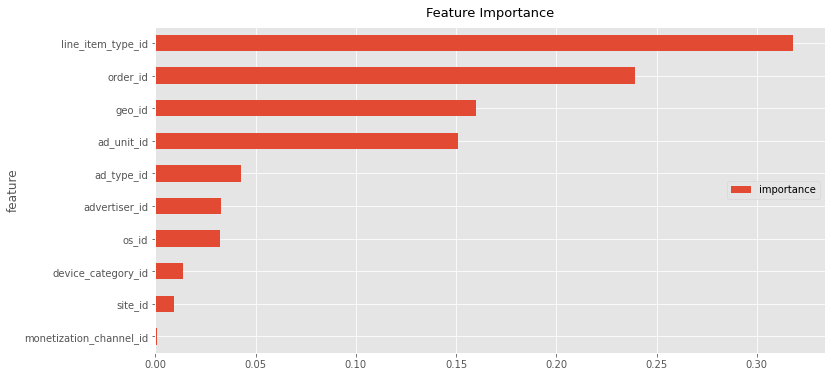

In [ ]:
# Plot the feature importance
feature_importance = pd.DataFrame({'feature':feature_list, 'importance':tree_reg.feature_importances_}).sort_values(by='importance')
ax = feature_importance.plot(x='feature', y='importance', kind='barh', figsize=(12,6))
ax.set_title("Feature Importance", fontsize=13, pad=10)
ax.legend(loc='center right');

#### Improve Model w/ Hyperparamater Tuning

Make a bunch of different models with different settings, evaluate them all on the same validation set, and see which one does the best. We'll try to tune two hyperparameters `max_depth, and max_features`. (Warning: This can be computationally expensive!)

Tune `max_depth`

In [ ]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 40))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 5-fold cross-validation with each value of max_depth
for depth in max_depth_range:
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    MSE_scores = cross_val_score(tree_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

KeyboardInterrupt: ignored

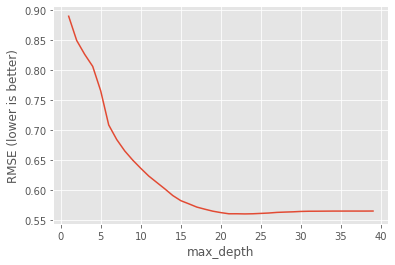

In [ ]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

Tune `max_features`

In [ ]:
# List of values to try for max_features:
max_features_range = list(range(1, 10))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 5-fold cross-validation with each value of max_depth
for feature in max_features_range:
    tree_reg = DecisionTreeRegressor(max_features=feature, random_state=42)
    MSE_scores = cross_val_score(tree_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

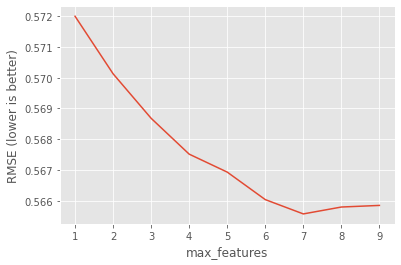

In [ ]:
# Plot max_features (x-axis) versus RMSE (y-axis).
plt.plot(max_features_range, RMSE_scores);
plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

In [ ]:
# Re-train the Decision Tree model with the new hyper parameters

# Instantiate model with new hyper parameters
tree_reg_hp = DecisionTreeRegressor(max_depth=20, max_features=7)

# Train the model on training data
tree_reg_hp.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred_hp = tree_reg_hp.predict(X_test)

# Display performance metrics
print("R Squared: {:.3f}".format(tree_reg_hp.score(X_test, y_test)))
print('')
print("TEST MSE   : {:.3f}".format(mean_squared_error(y_test, y_test_pred_hp)))
print("TEST RMSE  : {:.3f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred_hp))))

R Squared: 0.700

TEST MSE   : 0.313
TEST RMSE  : 0.559


**Summary:** Our decision tree model performs about the same out of the box versus after tuning the `max_depth` and `max_features` hyperparmeters. Lets try another model to see if we can get better predictions.

### Random Forest Regressor
Random forests are an ensemble method where hundreds (or thousands) of individual decision trees are fit to boostrap re-samples of the original dataset, with each tree being allowed to use a random selection of N variables, where N is the major configurable parameter of this algorithm. Ensembling many re-sampled decision trees serves to reduce their variance, producing more stable estimators that generalize well out-of-sample. Random forests are extrememly hard to over-fit, are very accurate, generalize well, and require little tuning.


In [ ]:
# Instantiate Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)

# Get Default Paramaters
rf_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Train the model on training data
rf_reg.fit(X_train,y_train)

# Predict using test set
y_pred = rf_reg.predict(X_test)

In [ ]:
# Display performance metrics
print("R Squared  : {:.3f}".format(rf_reg.score(X_test, y_test))) # Return the coefficient of determination of the prediction.
print('MSE Score  : {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE Score : {:.3f}'.format((np.sqrt(mean_squared_error(y_test, y_pred)))))

R Squared  : 0.717
MSE Score  : 0.296
RMSE Score : 0.545


**Interpretation:** Out of the box, our random forest model has learned how to predict the CPM with a 71% accuracy. We saw a 0.013 or 4.2% improvement in MSE (0.298 vs 0.311) with our Random Forest model compared to our Decision Tree model. Not bad, could we do better by tuning our hyper parameters?



#### Improve Model w/ Hyperparameter Tuning

We will attempt to improve the model by adjusting the settings for these three hyperparameters: `n_estimators, max_features, and min_samples_split`. (Warning: This can be computationally expensive!)

In [ ]:
# List of values to try for n_estimators:
estimator_range = list(range(10, 200, 10))

# List to store the average RMSE for each value of n_estimators:
mse_scores = []

# Use five-fold cross-validation with each value of n_estimators (Warning: Slow!).
for estimator in estimator_range:
    rf_reg = RandomForestRegressor(n_estimators=estimator, random_state=42)
    MSE_score = cross_val_score(rf_reg, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores.append(np.mean((-MSE_score)))

# Find the average RMSE
print('Average RMSE: {:.3f}'.format(np.mean(np.sqrt(mse_scores))))

**Summary:** At this point, our model performs pretty decent at 71% accuracy. But this is pretty much a black box approach. We basically feed the random forest model some data to train on, asked it to make a prediction, then we evaluate the predictions and ask ourselves if they seem reasonable, but we really don't know how the model arrived at these predictions.

There are a couple of ways we can figure out how the "sausage" is made. 
1. Look at the feature importances of our explantory variables.
2. Look at a single tree in the forest and see how the model is making each split

#### Intepret Model Results

In [ ]:
# Compute feature importance
feature_importance = pd.DataFrame({'feature': feature_list, 'importance': rf_reg.feature_importances_}).sort_values('importance', ascending=False)
feature_importance

,feature,importance
3,line_item_type_id,0.310481
1,order_id,0.233482
7,geo_id,0.164882
5,ad_unit_id,0.157155
6,ad_type_id,0.041822
0,advertiser_id,0.033784
9,os_id,0.033387
8,device_category_id,0.014446
4,site_id,0.009481
2,monetization_channel_id,0.001080


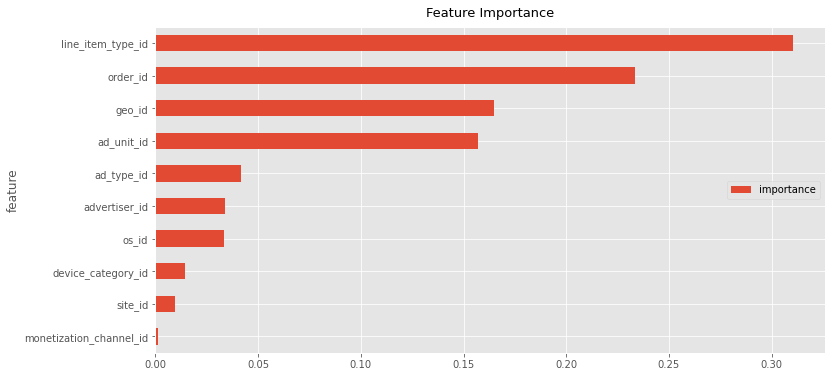

In [ ]:
# Plot the feature importance
feature_importance = pd.DataFrame({'feature': feature_list, 'importance': rf_reg.feature_importances_}).sort_values('importance')
ax = feature_importance.plot(x='feature', y='importance', kind='barh', figsize=(12,6))
ax.set_title("Feature Importance", fontsize=13, pad=10)
ax.legend(loc='center right');

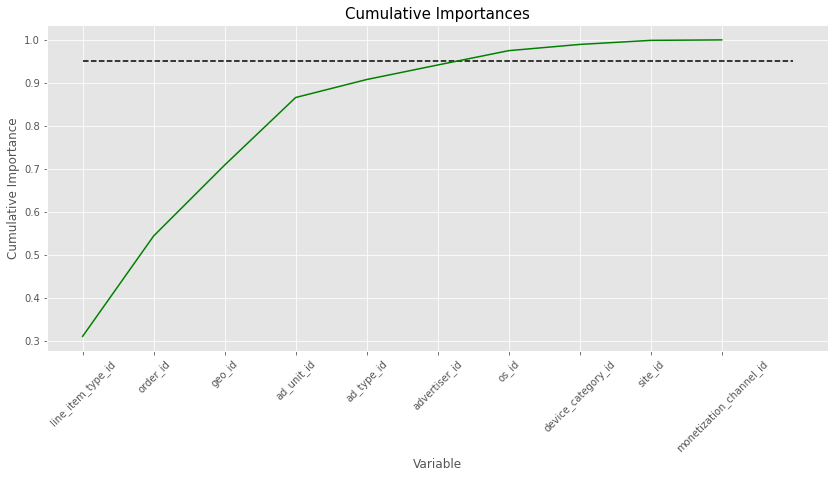

In [ ]:
# Plot the cumulative feature importance

# Sort Feature Importance
sorted_feature_importances = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
sorted_feature_importances = sorted_feature_importances['importance']

# Sort Features
sorted_features = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
sorted_features = sorted_features['feature']

# Cumulative importances
cumulative_importances = np.cumsum(sorted_feature_importances)

# Make a line graph
plt.figure(figsize=(14,6))
plt.plot(sorted_features, cumulative_importances, 'g-')

# Draw line at 95% of importance attained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_feature_importances), color = 'black', linestyles = 'dashed')
plt.xticks(sorted_features, sorted_features, rotation=45)
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); 
plt.title('Cumulative Importances', fontsize=15);

In [ ]:
# Display an example of a small tree and backtest it!

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth=3)
rf_small.fit(X_train, y_train)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

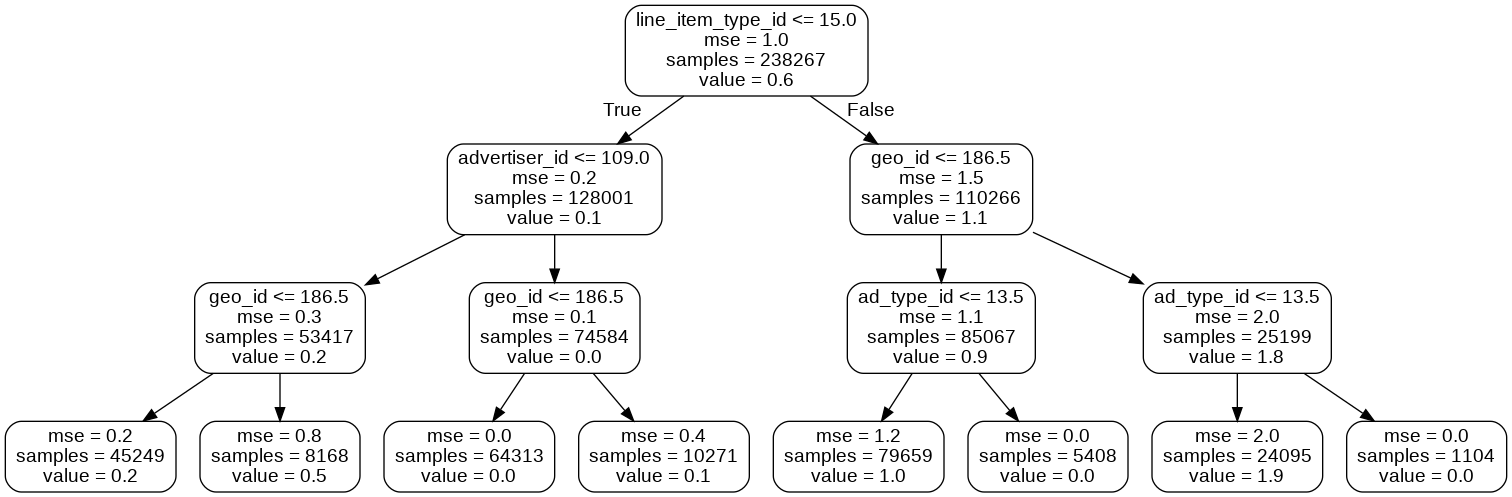

In [ ]:
# Validate a data point from the dataset using the top 5 feature, which makes up about 90% 
columns = ['date', 'line_item_type_id', 'advertiser_id', 'ad_type_id', 'geo_id',  'ad_unit_id', 'CPM']
pd.DataFrame(ads_df[columns].loc[110350])

,110350
date,2019-06-24 00:00:00
line_item_type_id,19
advertiser_id,90
ad_type_id,10
geo_id,187
ad_unit_id,5171
CPM,1.80235


**Interpretation:** 

Lets look at an example where we're making a prediction for July using a random day from June. The actual variables are line_item_type_id, advertiser_id, geo_id, ad_type_id. 

If we follow the tree down we will see we predicted a value of 1.9. 
1. Start a root node evaluate if `line_item_type_id <= 15`, its `False` so we move to the right
2. Next evaluate if `geo_id <= 186`, its `False` so we move to the right again
3. Lastly, evaluate if `ad_type_id <= 13.5`, its `True` so we move left and end at 1.9 as our predicted CPM value.

The root node only has 238k/538k data points. This is because in a random forest, each tree is trained on a random subset of the data points with replacement. Random sample of data points, combined with random sampling of a subset of features at each node of the tree is why the model is called a "random" forest.

### Save Predictions / Model

In [ ]:
# Predict values for entire dataset
predictions = rf_reg.predict(X)

In [ ]:
def prediction_accuracy(df):
  ads_df['pred_CPM'] = predictions
  ads_df['Error'] = ads_df['CPM'] - ads_df['pred_CPM']
  ads_df['Pct_Error'] = ads_df['Error'] / ads_df['pred_CPM']
  accuracy = ads_df['Pct_Error'] * 100
  ads_df['Accuracy'] = abs(100 - abs(accuracy))
  return df

prediction_accuracy(ads_df)

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent,year,month,day,weekday,day_of_week,revenue_per_imp,CPM,pred_CPM,Error,Pct_Error,Accuracy
0,2019-06-30,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0000,2,16,1,2019,6,30,6,Sunday,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,2019-06-30,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0000,0,6,1,2019,6,30,6,Sunday,0.000000,0.000000,0.000000,0.000000,NaN,NaN
2,2019-06-30,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0000,0,4,1,2019,6,30,6,Sunday,0.000000,0.000000,0.000000,0.000000,NaN,NaN
3,2019-06-30,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0000,0,4,1,2019,6,30,6,Sunday,0.000000,0.000000,0.000000,0.000000,NaN,NaN
4,2019-06-30,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0000,0,4,1,2019,6,30,6,Sunday,0.000000,0.000000,0.008400,-0.008400,-1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567286,2019-06-01,350,10,187,3,79,3456,20,59,1,19,5168,12,0.0254,4,12,1,2019,6,1,5,Saturday,0.002117,2.116667,1.352730,0.763936,0.564737,43.526330
567287,2019-06-01,350,10,187,1,79,3456,20,56,1,19,5168,68,0.3400,52,66,1,2019,6,1,5,Saturday,0.005152,5.151515,2.378925,2.772590,1.165480,16.548042
567288,2019-06-01,350,10,158,1,79,3456,20,56,1,19,5168,2,0.0046,0,2,1,2019,6,1,5,Saturday,0.002300,2.300000,1.086575,1.213425,1.116742,11.674243
567289,2019-06-01,350,10,33,1,79,3456,20,56,1,19,5168,6,0.0120,0,6,1,2019,6,1,5,Saturday,0.002000,2.000000,1.646570,0.353430,0.214646,78.535357


In [ ]:
# Save model predictions
ads_df.to_csv('/content/drive/MyDrive/Data/rtb-ads-dataset-predictions.csv', index=False)

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Data/rtb-ads-dataset-predictions.parquet.gzip')
df.head()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent,year,month,day,weekday,day_of_week,revenue_per_imp,CPM,pred_CPM,Error,Pct_Error,Accuracy
0,2019-06-30,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0,2,16,1,2019,6,30,6,Sunday,0.0,0.0,0.0000,0.0000,NaN,NaN
1,2019-06-30,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0,0,6,1,2019,6,30,6,Sunday,0.0,0.0,0.0000,0.0000,NaN,NaN
2,2019-06-30,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0,0,4,1,2019,6,30,6,Sunday,0.0,0.0,0.0000,0.0000,NaN,NaN
3,2019-06-30,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0,0,4,1,2019,6,30,6,Sunday,0.0,0.0,0.0000,0.0000,NaN,NaN
4,2019-06-30,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0,0,4,1,2019,6,30,6,Sunday,0.0,0.0,0.0084,-0.0084,-1.0,0.0


In [ ]:
import pickle

In [ ]:
# context manager: opens file > write file > close out file
# .pkl extension, wb = write byte, assign alias
# Warning: only pickle files you know of or wrote. They can be embedded code that has virus or malicious code.
with open('/content/drive/MyDrive/Data/rf_reg.pkl', 'wb') as pickle_file:
  pickle.dump(rf_reg, pickle_file)

### Next Steps & Ideas to Improve Model Performance

- All observations with line_item_type = 3, 9, 11 all receive impressions but 0 CPM value. We can try to exclude these observations from our dataset to improve the accuracy of our model.
- Try excluding unimportant features for future model iterations
- Try different train/test splits (90/10, 80/20, 70/30, time-series-split) to see if our model's performance improves.
- Try different hyperparameters (settings). However, need to weigh the tradeoff between decrease in accuracy versus the extra time required to train the models (performance vs cost from computation resources).
- Try different ml algorithms such as XGB, LGB, and CAT
- Add more data! As of now, we are confident our model can predict the reserve CPM with 71% accuracy from one month of data. 
- Create mapping function to apply "category labels" to explantatory variables (numerical IDs) to gain more context and insights into ID values.
- Deploy model into a production enviornment and track prediction CPM vs actual CPM accuracy over time (Daily, Weekly cadence).
- Build an app using streamlit so end-users can toggle different configurations to get reserve CPMs

### Closing Remarks

Overall, this publisher who owns multiple website makes about 40k/month or 480k/year on ad revenue. Programmatic advertising uses your reserve CPM rates to select the highest bidder. When your reserve CPM are outdated, your ad networks would be competing with incorrect rates, preventing you from maximizing ad revenue. With this CPM predictor, you could increase your revenue by updating your CPM rates at least once per month. Then you can run optimization tests to determine the sweet spot between maximizing ad utilization and revenue.

# Model Selection (Continued)

### Random Search with Cross Validation

We'll use a random search cross validation model to identify the best hyperparameters we should use. The RandomizedSearchCV method from the sklearn library returns a grid of hyperparameters randomly sample for each K-fold cross validation.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Create the random grid
random_grid = {'bootstrap': [True, False], # method of sampling data points
               'max_depth': [10, 25, 50, 100, 150, 200, None], # max number of levels in each decision tree
               'max_features': ['auto'], # max number of features considered for splitting a node
               'min_samples_leaf': [1, 5], # min number of data points allowed in a leaf node
               'min_samples_split': [2, 5, 10], # min number of data points placed in a node before the node is split
               'n_estimators': [10, 25, 50, 100, 150, 200] # number of trees in the forest
               }

random_grid

{'bootstrap': [True, False],
 'max_depth': [10, 25, 50, 100, 150, 200, None],
 'max_features': ['auto'],
 'min_samples_leaf': [1, 5],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 25, 50, 100, 150, 200]}

In [ ]:
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_ite=100, scoring='neg_mean_absolute_error', 
                              cv=3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 70.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 141.0min finished


In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 178}

In [ ]:
cv_results = pd.DataFrame.from_dict(rf_random.cv_results_)
print(cv_results.shape)
cv_results.sort_values('rank_test_score', ascending=False).head(2).T

### Grid Search Cross Validation

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {'bootstrap': [True],
              'max_depth': [None],
              'max_features': [0.4],
              'min_samples_leaf': [5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [150, 200, 250]
              }

# Create a based model
rf_reg = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_reg, param_grid=param_grid, cv=3, n_jobs =-1, verbose=2, return_train_score=True)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 12.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 0.4,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 250}

In [ ]:
gs_cv_results = pd.DataFrame.from_dict(grid_search.cv_results_)
print(gs_cv_results.shape)
gs_cv_results.sort_values('rank_test_score', ascending=False).head(2)

(9, 22)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,64.889276,0.813912,4.867501,0.036780,True,None,0.4,5,12,150,"{'bootstrap': True, 'max_depth': None, 'max_features': 0.4, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 150}",0.712094,0.722316,0.725282,0.719897,0.005649,9,0.761336,0.757802,0.755599,0.758246,0.002363
7,87.627641,1.069188,6.535550,0.207976,True,None,0.4,5,12,200,"{'bootstrap': True, 'max_depth': None, 'max_features': 0.4, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 200}",0.712174,0.722320,0.725461,0.719985,0.005670,8,0.761494,0.757785,0.755720,0.758333,0.002389


### Random Forest Regressor w/ Only Important Features (5)

In [ ]:
# Instantiate another Random Forest Model
rf_most_important = RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
# Select the 4 most important features
important_features =  ['line_item_type_id', 'order_id', 'ad_type_id', 'geo_id',  'ad_unit_id']

X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

In [ ]:
# Train the Random Forest
rf_most_important.fit(X_train_important, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# Make predictions using test set
predictions = rf_most_important.predict(X_test_important)

In [ ]:
# Calculate the errors
errors = abs(predictions - y_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
accuracy = rf_most_important.score(X_test_important, y_test)


# Display performance metrics
print('*** Performance Metrics ***')
print('R Squared: {:.3f}'.format(accuracy))
print('MAE Score  :', round(np.mean(errors), 2))
print('MSE Score  : {:.3f}'.format(mse))
print('RMSE Score : {:.3f}'.format(rmse))

*** Performance Metrics ***
R Squared: 0.680
MAE Score  : 0.29
MSE Score  : 0.334
RMSE Score : 0.578


**Interpretation:** This tells us that our model perfom worse when we have fewer features to train on. By adding more features, our model does a better job at finding the relationships between our features and labels to accurately predict CPM.

### Model Evaluation Function

In [ ]:
def weird_division(n, d):
    return n / d if d else 0

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    accuracy = model.score(X_test, y_test)
    print('Model Performance')
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('R Squared: = {:0.2f}'.format(accuracy))
    
    return accuracy

In [ ]:
# Base Model
base_model = RandomForestRegressor(n_estimators=10, random_state=42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.2655
R Squared: = 0.71


In [ ]:
# Random Search Best Model
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
# Grid Search Best Model
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

## Model Comparison

# Parking Lot

### Alternative Models

In [ ]:
!pip install catboost --quiet
!pip install gboost --quiet
!pip install lightgbm --quiet

In [ ]:
from catboost import CatBoostRegressor
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
models = {'DecisionTree': DecisionTreeRegressor(random_state=42),
          'RandomForest': RandomForestRegressor(criterion='mse', n_jobs=-1),
          'LGBM': LGBMRegressor(objective='mse', n_jobs=-1),
          'CatBoost': CatBoostRegressor(objective='RMSE', verbose=0),
          'XGB': XGBRFRegressor(objective='reg:squarederror')
         }

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Model: {}, Score: {:.3f}".format(name, mean_squared_error(y_test, y_pred)))

Model: DecisionTree, Score: 0.881
Model: RandomForest, Score: 0.836
Model: LGBM, Score: 0.838
Model: CatBoost, Score: 0.799
Model: XGB, Score: 1.935


In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Model: {}, Score: {:.3f}".format(name, np.sqrt(mean_squared_error(y_test, y_pred))))

Model: DecisionTree, Score: 0.938
Model: RandomForest, Score: 0.913
Model: LGBM, Score: 0.915
Model: CatBoost, Score: 0.894
Model: XGB, Score: 1.391


### Alternative Train/Test Split

In [ ]:
train_date = datetime.datetime(2019, 6, 22)

In [ ]:
X_train = ads_df[ads_df['date'] < train_date][feature_list]
y_train = ads_df.loc[ads_df['date'] < train_date][target_col]
X_test = ads_df.loc[ads_df['date'] >= train_date][feature_list]
y_test = ads_df.loc[ads_df['date'] >= train_date][target_col]

print('***** TRAIN/TEST SPLIT *****')
print('TOTAL :', X.shape, y.shape)
print('TRAIN :', X_train.shape, y_train.shape)
print('TEST  :', X_test.shape, y_test.shape)
print('')
print('Ratio : {}'.format(round(X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]),3)))

***** TRAIN/TEST SPLIT *****
TOTAL : (538924, 10) (538924,)
TRAIN : (376973, 10) (376973,)
TEST  : (161951, 10) (161951,)

Ratio : 0.699


### Cross Validation

In [ ]:
cv = cross_validate(tree_reg, X, y, cv=5)

for i in range(len(cv['test_score'])):
  print("CV {} Score: {:.3f}".format(i, cv['test_score'][i]))

print('')
print("Mean Score: {:.3f}".format(cv['test_score'].mean()))